In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
os.chdir('../')

In [2]:
df = pd.read_csv('output/input_2021-10-01.csv.gz')

if not os.path.exists('output/oct'):
    os.mkdir('output/oct')

def produce_matrix(columns_list, names, filename, size=(7, 7)):
    confusion_matrix = []
    for i in columns_list:
        row = []
        for j in columns_list:
            equal = i.eq(j).sum()
            row.append(int(round_to_5(equal)))

        confusion_matrix.append(row)


    plt.figure(figsize=size)
    mask = np.zeros_like(confusion_matrix)
    mask[np.triu_indices_from(mask, k=1)] = True

    with sn.axes_style("white"):

        sn.heatmap(confusion_matrix, mask=mask, annot=True, fmt="d", xticklabels=names, yticklabels=names)
        plt.yticks(rotation=0) 
        plt.savefig(f"output/oct/{filename}.jpeg", bbox_inches='tight')
        plt.show()
        
def round_to_5(number):
    return 5 * round((number / 5))

def performance_metrics(tp, fp, tn, fn):
    tp = round_to_5(tp)
    fp = round_to_5(fp)
    tn = round_to_5(tn)
    fn = round_to_5(fn)
    
    sensitivity = round((tp/(tp+fn)) *100, 2)
    specificity = round((tn/(tn+fp)) *100, 2)
    fdr = round((fp/(fp+tp)) *100, 2)
    return [tp, fp, sensitivity, specificity, fdr]

## Number of emergency covid hospital admissions and those that can be identified in A&E attendances
### Any A&E attendance

In [6]:
num_emergency_cov_admissions = round_to_5(df['emergency_covid_hospital_admission_date'].count())
ae_before = (df.loc[
    df["ae_before_date"].notnull()
, "patient_id"])

print(f'Number of emergency covid hospital admissions: {num_emergency_cov_admissions}')
print(f'Number with A&E attendance before admission: {round_to_5(len(ae_before))} ({round((round_to_5(len(ae_before))/num_emergency_cov_admissions)*100, 2)}%)')

ae = round_to_5(len(df[
    (df["ae_attendance_date"].notnull())
]))

ae_with_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull())
]))

summary_table = pd.DataFrame({
    "emergency covid hospital admission": num_emergency_cov_admissions,
    "ae attendance before admission": round_to_5(len(ae_before)),
    "ae_attendance": ae, 
    "ae attendance with hospital discharge": ae_with_hosp_discharge,
    
}, index=["count"])

summary_table.to_csv("output/oct/summary_table.csv")

print('---')
print(f'Number of A&E attendances: {ae}')

Number of emergency covid hospital admissions: 0
---
Number of A&E attendances: 0


#### Method 1 - Discharge destination
Restrict to those that attended A&E and had a hospital discharge destination (hospital ward, emergency short stay ward, icu).

In [7]:
ae_hosp_before = (df.loc[
    df["ae_before_with_hospital_discharge_date"].notnull()
, "patient_id"])

print(f'Number with A&E attendance with hospital discharge before admission: {round_to_5(len(ae_hosp_before))} ({round((round_to_5(len(ae_hosp_before))/num_emergency_cov_admissions)*100, 2)}%)')


# false posisitves
fp_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)

]))

tp_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)

]))

tn_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].isnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)

]))

fn_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].isnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)

]))

discharge_destination = performance_metrics(tp_ae_hosp_discharge, fp_ae_hosp_discharge, tn_ae_hosp_discharge, fn_ae_hosp_discharge)

print(f'False positives (FDR): {fp_ae_hosp_discharge} ({discharge_destination[4]}%)')

ZeroDivisionError: division by zero

#### Method 2 - Diagnosis code
Restrict to those with a COVID-19 diagnosis code or respiratory-related diagnosis code from the [emergency care diagnosis refset](https://termbrowser.nhs.uk/?perspective=full&conceptId1=991411000000109&edition=uk-edition&release=v20220216&server=https://termbrowser.nhs.uk/sct-browser-api/snomed&langRefset=900000000000508004)

In [7]:
ae_cov_before = (df.loc[
    df["ae_before_with_covid"]==1
, "patient_id"])

ae_resp_before = (df.loc[
    df["ae_before_with_resp"]==1
, "patient_id"])

print(f'Number with A&E attendance and covid diagnosis code before admission: {round_to_5(len(ae_cov_before))} ({round((round_to_5(len(ae_cov_before))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and respiratory code before admission: {round_to_5(len(ae_resp_before))} ({round((round_to_5(len(ae_resp_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_cov = round_to_5(len(df[
    (df["ae_cov"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fp_ae_resp = round_to_5(len(df[
    (df["ae_resp"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tp_ae_cov = round_to_5(len(df[
    (df["ae_cov"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tp_ae_resp = round_to_5(len(df[
    (df["ae_resp"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tn_ae_cov = round_to_5(len(df[
    (df["ae_cov"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tn_ae_resp = round_to_5(len(df[
    (df["ae_resp"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fn_ae_cov = round_to_5(len(df[
    (df["ae_cov"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

fn_ae_resp = round_to_5(len(df[
    (df["ae_resp"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

diagnosis_code_cov = performance_metrics(tp_ae_cov, fp_ae_cov, tn_ae_cov, fn_ae_cov)
diagnosis_code_resp = performance_metrics(tp_ae_resp, fp_ae_resp, tn_ae_resp, fn_ae_resp)

print(f'False positives (FDR) - A&E attendance and covid diagnosis code: {fp_ae_cov} ({diagnosis_code_cov[4]}%)')
print(f'False positives (FDR) - A&E attendance and respiratory diagnosis code: {fp_ae_resp} ({diagnosis_code_resp[4]}%)')

Number with A&E attendance and covid diagnosis code before admission: 500 (166.67%)
Number with A&E attendance and respiratory code before admission: 500 (166.67%)
False positives (FDR) - A&E attendance and covid diagnosis code: 350 (70.0%)
False positives (FDR) - A&E attendance and respiratory diagnosis code: 350 (70.0%)


#### Method 3 - Identification in primary care

Restrict to those with a probable or suspected COVID-19 code recorded in primary care in the 2 weeks prior to A&E attendance.

In [8]:
ae_prim_care_probable_before = (df.loc[
    df["ae_before_with_prim_care_probable"]==1
, "patient_id"])

ae_prim_care_suspected_before = (df.loc[
    df["ae_before_with_prim_care_suspected"]==1
, "patient_id"])

print(f'Number with A&E attendance and recent suspected covid code in primary care before admission: {round_to_5(len(ae_prim_care_suspected_before))} ({round((round_to_5(len(ae_prim_care_suspected_before))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and recent probable covid code in primary care before admission: {round_to_5(len(ae_prim_care_probable_before))} ({round((round_to_5(len(ae_prim_care_probable_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)    
]))

fp_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
]))

tp_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)    
]))

tp_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
]))

tn_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)    
]))

tn_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
]))

fn_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)    
]))

fn_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
]))



prim_care_suspected = performance_metrics(tp_ae_suspected, fp_ae_suspected, tn_ae_suspected, fn_ae_suspected)
prim_care_probable = performance_metrics(tp_ae_probable, fp_ae_probable, tn_ae_probable, fn_ae_probable)
print(f'False positives (FDR) - A&E attendance and probable covid code in primary care: {prim_care_probable[4]}%)')
print(f'False positives (FDR) - A&E attendance and suspected covid code in primary care: {prim_care_suspected[4]}%)')

Number with A&E attendance and recent suspected covid code in primary care before admission: 500 (166.67%)
Number with A&E attendance and recent probable covid code in primary care before admission: 500 (166.67%)
False positives (FDR) - A&E attendance and probable covid code in primary care: 72.0%)
False positives (FDR) - A&E attendance and suspected covid code in primary care: 68.0%)


#### Method 4 - Positive test result

Restrict to those with a positive COVID-19 test result recorded up to 4 weeks prior to A&E attendance.

In [9]:
ae_pos_test_before_2_weeks = (df.loc[
    df["ae_before_with_positive_covid_test_2_weeks"]==1
, "patient_id"])

ae_pos_test_before = (df.loc[
    df["ae_before_with_positive_covid_test"]==1
, "patient_id"])


print(f'Number with A&E attendance and recent positive test (2 weeks) before admission: {round_to_5(len(ae_pos_test_before_2_weeks))} ({round((round_to_5(len(ae_pos_test_before_2_weeks))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and recent positive test (4 weeks) before admissio: {round_to_5(len(ae_pos_test_before))} ({round((round_to_5(len(ae_pos_test_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_test = round_to_5(len(df[
    (df["pos_test"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fp_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tp_ae_test = round_to_5(len(df[
    (df["pos_test"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tp_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tn_ae_test = round_to_5(len(df[
    (df["pos_test"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tn_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fn_ae_test = round_to_5(len(df[
    (df["pos_test"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

fn_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))


positive_test_2_weeks = performance_metrics(tp_ae_test_2_weeks, fp_ae_test_2_weeks, tn_ae_test_2_weeks, fn_ae_test_2_weeks)
positive_test_4_weeks = performance_metrics(tp_ae_test, fp_ae_test, tn_ae_test, fn_ae_test)

print(f'False positives (FDR) - A&E attendance and recent positive test (2 weeks): {fp_ae_test_2_weeks} ({positive_test_2_weeks[4]}%)')
print(f'False positives (FDR) - A&E attendance and recent positive test (4 weeks): {fp_ae_test} ({positive_test_4_weeks[4]}%)')


Number with A&E attendance and recent positive test (2 weeks) before admission: 500 (166.67%)
Number with A&E attendance and recent positive test (4 weeks) before admissio: 500 (166.67%)
False positives (FDR) - A&E attendance and recent positive test (2 weeks): 340 (68.0%)
False positives (FDR) - A&E attendance and recent positive test (4 weeks): 350 (70.0%)


####  Combining approaches

##### Diagnosis codes (resp or cov) with recent positive test

In [11]:
ae_hos_resp_cov_plus_test_2_weeks = (df.loc[(
        (df["ae_before_with_covid"]==1) | 
        (df["ae_before_with_resp"]==1) 
    )&
    (df["ae_before_with_positive_covid_test_2_weeks"]==1)
, "patient_id"])

print(f'Number with A&E attendance with either covid or respiratory diagnosis code and recent positive test (2 weeks) before admission: {round_to_5(len(ae_hos_resp_cov_plus_test_2_weeks))} ({round((round_to_5(len(ae_hos_resp_cov_plus_test_2_weeks))/num_emergency_cov_admissions)*100, 2)}%)')


fp_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tp_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tn_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    ~(
    (
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fn_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    ~(
    (
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))


code_plus_test = performance_metrics(tp_ae_hos_resp_cov_plus_test_2_weeks, fp_ae_hos_resp_cov_plus_test_2_weeks, tn_ae_hos_resp_cov_plus_test_2_weeks, fn_ae_hos_resp_cov_plus_test_2_weeks)
print(f'False positives (FDR): {fp_ae_hos_resp_cov_plus_test_2_weeks} ({code_plus_test[4]}%)')


Number with A&E attendance with either covid or respiratory diagnosis code and recent positive test (2 weeks) before admission: 365 (121.67%)
False positives (FDR): 265 (68.83%)


##### Covid in primary care with recent positive test

In [12]:
ae_hosp_prim_care_before_plus_2_week_test = (df.loc[
    
    
    (
        (df["ae_before_with_prim_care_suspected"]==1) | 
        (df["ae_before_with_prim_care_probable"]==1) 
    )
&
    (df["ae_before_with_positive_covid_test_2_weeks"]==1)
, "patient_id"])

print(f'Number with A&E attendance with suspected or probable covid in primary care and recent positive test (2 weeks) before admission: {round_to_5(len(ae_hosp_prim_care_before_plus_2_week_test))} ({round((round_to_5(len(ae_hosp_prim_care_before_plus_2_week_test))/num_emergency_cov_admissions)*100, 2)}%)')


fp_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tp_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tn_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (~
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fn_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (~
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))


primary_care_plus_test = performance_metrics(tp_ae_hosp_prim_care_before_plus_2_week_test, fp_ae_hosp_prim_care_before_plus_2_week_test, tn_ae_hosp_prim_care_before_plus_2_week_test, fn_ae_hosp_prim_care_before_plus_2_week_test)

print(f'False positives (FDR): {fp_ae_hosp_prim_care_before_plus_2_week_test} ({primary_care_plus_test[4]}%)')


Number with A&E attendance with suspected or probable covid in primary care and recent positive test (2 weeks) before admission: 375 (125.0%)
False positives (FDR): 260 (67.53%)


##### Recent positive test and either covid in primary care or diagnosis code (resp or cov)

In [13]:
combined_before = (df.loc[
        (df["ae_before_with_positive_covid_test_2_weeks"]==1) &
        (
            (df["ae_before_with_prim_care_suspected"]==1) | 
            (df["ae_before_with_prim_care_probable"]==1) |
            (df["ae_before_with_covid"]==1) | 
            (df["ae_before_with_resp"]==1)   
        )
, "patient_id"])

print(f'Number with A&E attendance with recent positive test and either suspected or probable covid in primary care or a covid or respiratory diagnosis code on attendance: {round_to_5(len(combined_before))} ({round((round_to_5(len(combined_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_combined_before = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1) |
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)
        
        
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tp_combined_before = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1) |
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tn_combined_before = round_to_5(len(df[
    (~
        (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1) |
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)
    )&
    (df["pos_test_2_weeks"]==1)
    )
    & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fn_combined_before = round_to_5(len(df[
    (~
        (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1) |
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)
    )&
    (df["pos_test_2_weeks"]==1)
    )
    & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

pos_test_prim_care_or_diagnosis_code = performance_metrics(tp_combined_before, fp_combined_before, tn_combined_before, fn_combined_before)
print(f'False positives (FDR): {fp_combined_before} ({pos_test_prim_care_or_diagnosis_code[4]}%)')


Number with A&E attendance with recent positive test and either suspected or probable covid in primary care or a covid or respiratory diagnosis code on attendance: 465 (155.0%)
False positives (FDR): 320 (68.09%)


In [15]:
identification_table_index = ["tp", "fp", "sensitivity", "specificity", "fdr"]
identification_table = pd.DataFrame({
    "discharge_destination": pd.Series(discharge_destination,index=identification_table_index),
    "covid_diagnosis_code": pd.Series(diagnosis_code_cov,index=identification_table_index),
    "resp_diagnosis_code": pd.Series(diagnosis_code_resp,index=identification_table_index),
    "primary_care_suspected": pd.Series(prim_care_suspected,index=identification_table_index),
    "primary_care_probable": pd.Series(prim_care_probable,index=identification_table_index),
    "positive_test_2_weeks": pd.Series(positive_test_2_weeks,index=identification_table_index),
    "positive_test_4_weeks": pd.Series(positive_test_4_weeks,index=identification_table_index),
    "diagnosis_code_with_positive_test": pd.Series(code_plus_test,index=identification_table_index),
    "primary_care_with_positive_test": pd.Series(primary_care_plus_test,index=identification_table_index),
    "pos_test_prim_care_or_diagnosis": pd.Series(pos_test_prim_care_or_diagnosis_code,index=identification_table_index)
    
})
identification_table.to_csv("output/oct/identification_table_no_hosp_discharge.csv")

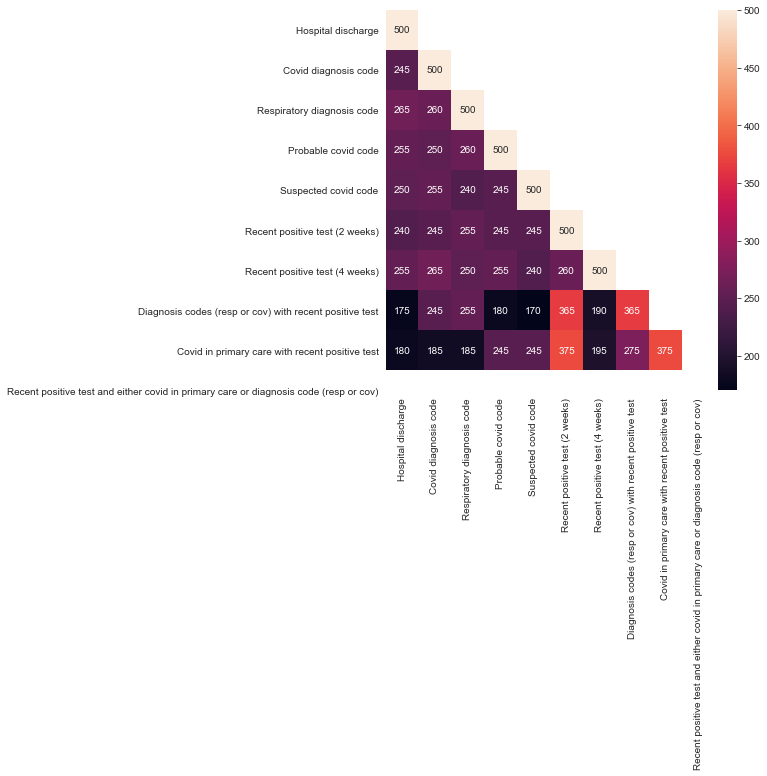

In [16]:
produce_matrix(columns_list = [ae_hosp_before, ae_cov_before, ae_resp_before, ae_prim_care_probable_before, ae_prim_care_suspected_before, ae_pos_test_before_2_weeks, ae_pos_test_before, ae_hos_resp_cov_plus_test_2_weeks, ae_hosp_prim_care_before_plus_2_week_test], names=["Hospital discharge", "Covid diagnosis code", "Respiratory diagnosis code", "Probable covid code", "Suspected covid code", "Recent positive test (2 weeks)", "Recent positive test (4 weeks)", "Diagnosis codes (resp or cov) with recent positive test", "Covid in primary care with recent positive test", "Recent positive test and either covid in primary care or diagnosis code (resp or cov)"], filename="cm_no_hosp_discharge")


### Restrict to A&E attendance with hospital discharge

In [17]:
ae_with_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull())
]))
print(f'Number of A&E attendances with hospital discharge: {ae_with_hosp_discharge}')

Number of A&E attendances with hospital discharge: 400


#### Method 1 - Discharge destination
Restrict to those that attended A&E and had a hospital discharge destination (hospital ward, emergency short stay ward, icu).

In [18]:
ae_hosp_before = (df.loc[
    df["ae_before_with_hospital_discharge_date"].notnull()
, "patient_id"])

print(f'Number with A&E attendance with hospital discharge before admission: {round_to_5(len(ae_hosp_before))} ({round((round_to_5(len(ae_hosp_before))/num_emergency_cov_admissions)*100, 2)}%)')


# false posisitves
fp_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)

]))

tp_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)

]))

tn_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].isnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)

]))

fn_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].isnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)

]))

discharge_destination = performance_metrics(tp_ae_hosp_discharge, fp_ae_hosp_discharge, tn_ae_hosp_discharge, fn_ae_hosp_discharge)
print(f'False positives (FDR): {fp_ae_hosp_discharge} ({discharge_destination[4]}%)')

Number with A&E attendance with hospital discharge before admission: 500 (166.67%)
False positives (FDR): 280 (70.0%)


#### Method 2 - Diagnosis code
Restrict to those with a COVID-19 diagnosis code or respiratory-related diagnosis code from the [emergency care diagnosis refset](https://termbrowser.nhs.uk/?perspective=full&conceptId1=991411000000109&edition=uk-edition&release=v20220216&server=https://termbrowser.nhs.uk/sct-browser-api/snomed&langRefset=900000000000508004)

In [20]:
ae_cov_before = (df.loc[
    df["ae_before_with_hospital_discharge_covid"]==1
, "patient_id"])

ae_resp_before = (df.loc[
    df["ae_before_with_hospital_discharge_resp"]==1
, "patient_id"])

print(f'Number with A&E attendance and covid diagnosis code before admission: {round_to_5(len(ae_cov_before))} ({round((round_to_5(len(ae_cov_before))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and respiratory code before admission: {round_to_5(len(ae_resp_before))} ({round((round_to_5(len(ae_resp_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_cov = round_to_5(len(df[
    (df["ae_cov_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fp_ae_resp = round_to_5(len(df[
    (df["ae_resp_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tp_ae_cov = round_to_5(len(df[
    (df["ae_cov_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tp_ae_resp = round_to_5(len(df[
    (df["ae_resp_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tn_ae_cov = round_to_5(len(df[
    (df["ae_cov_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tn_ae_resp = round_to_5(len(df[
    (df["ae_resp_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fn_ae_cov = round_to_5(len(df[
    (df["ae_cov_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

fn_ae_resp = round_to_5(len(df[
    (df["ae_resp_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))



diagnosis_code_cov = performance_metrics(tp_ae_cov, fp_ae_cov, tn_ae_cov, fn_ae_cov)
diagnosis_code_resp = performance_metrics(tp_ae_resp, fp_ae_resp, tn_ae_resp, fn_ae_resp)

print(f'False positives (FDR) - A&E attendance and covid diagnosis code: {fp_ae_cov} ({diagnosis_code_cov[4]}%)')
print(f'False positives (FDR) - A&E attendance and respiratory diagnosis code: {fp_ae_resp} ({diagnosis_code_resp[4]}%)')

Number with A&E attendance and covid diagnosis code before admission: 500 (166.67%)
Number with A&E attendance and respiratory code before admission: 500 (166.67%)
False positives (FDR) - A&E attendance and covid diagnosis code: 350 (70.0%)
False positives (FDR) - A&E attendance and respiratory diagnosis code: 335 (67.0%)


#### Method 3 - Identification in primary care

Restrict to those with a probable or suspected COVID-19 code recorded in primary care in the 2 weeks prior to A&E attendance.

In [21]:
ae_prim_care_probable_before = (df.loc[
    df["ae_before_with_hospital_discharge_prim_care_probable"]==1
, "patient_id"])

ae_prim_care_suspected_before = (df.loc[
    df["ae_before_with_hospital_discharge_prim_care_suspected"]==1
, "patient_id"])

print(f'Number with A&E attendance and recent suspected covid code in primary care before admission: {round_to_5(len(ae_prim_care_suspected_before))} ({round((round_to_5(len(ae_prim_care_suspected_before))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and recent probable covid code in primary care before admission: {round_to_5(len(ae_prim_care_probable_before))} ({round((round_to_5(len(ae_prim_care_probable_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)    
]))

fp_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
]))

tp_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)    
]))

tp_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
]))

tn_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)    
]))

tn_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
]))

fn_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)    
]))

fn_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
]))



prim_care_suspected = performance_metrics(tp_ae_suspected, fp_ae_suspected, tn_ae_suspected, fn_ae_suspected)
prim_care_probable = performance_metrics(tp_ae_probable, fp_ae_probable, tn_ae_probable, fn_ae_probable)

print(f'False positives (FDR) - A&E attendance and probable covid code in primary care: {fp_ae_probable} ({prim_care_probable[4]}%)')
print(f'False positives (FDR) - A&E attendance and suspected covid code in primary care: {fp_ae_suspected} ({prim_care_suspected[4]}%)')

Number with A&E attendance and recent suspected covid code in primary care before admission: 500 (166.67%)
Number with A&E attendance and recent probable covid code in primary care before admission: 500 (166.67%)
False positives (FDR) - A&E attendance and probable covid code in primary care: 350 (70.0%)
False positives (FDR) - A&E attendance and suspected covid code in primary care: 350 (70.0%)


#### Method 4 - Positive test result

Restrict to those with a positive COVID-19 test result recorded up to 4 weeks prior to A&E attendance.

In [22]:
ae_pos_test_before_2_weeks = (df.loc[
    df["ae_before_with_hospital_discharge_positive_covid_test_2_weeks"]==1
, "patient_id"])

ae_pos_test_before = (df.loc[
    df["ae_before_with_hospital_discharge_positive_covid_test"]==1
, "patient_id"])


print(f'Number with A&E attendance and recent positive test (2 weeks) before admission: {round_to_5(len(ae_pos_test_before_2_weeks))} ({round((round_to_5(len(ae_pos_test_before_2_weeks))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and recent positive test (4 weeks) before admissio: {round_to_5(len(ae_pos_test_before))} ({round((round_to_5(len(ae_pos_test_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_test = round_to_5(len(df[
    (df["pos_test_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fp_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tp_ae_test = round_to_5(len(df[
    (df["pos_test_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tp_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tn_ae_test = round_to_5(len(df[
    (df["pos_test_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tn_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fn_ae_test = round_to_5(len(df[
    (df["pos_test_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

fn_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

positive_test_2_weeks = performance_metrics(tn_ae_test_2_weeks, fp_ae_test_2_weeks, tn_ae_test_2_weeks, fn_ae_test_2_weeks)
positive_test_4_weeks = performance_metrics(tn_ae_test, fp_ae_test, tn_ae_test, fn_ae_test)

print(f'False positives (FDR) - A&E attendance and recent positive test (2 weeks): {fp_ae_test_2_weeks} ({positive_test_2_weeks[4]}%)')
print(f'False positives (FDR) - A&E attendance and recent positive test (4 weeks): {fp_ae_test} ({positive_test_4_weeks[4]}%)')

Number with A&E attendance and recent positive test (2 weeks) before admission: 500 (166.67%)
Number with A&E attendance and recent positive test (4 weeks) before admissio: 500 (166.67%)
False positives (FDR) - A&E attendance and recent positive test (2 weeks): 350 (50.0%)
False positives (FDR) - A&E attendance and recent positive test (4 weeks): 360 (51.43%)


####  Combining approaches

##### Diagnosis codes (resp or cov) with recent positive test

In [24]:
ae_hos_resp_cov_plus_test_2_weeks = (df.loc[(
        (df["ae_before_with_hospital_discharge_covid"]==1) | 
        (df["ae_before_with_hospital_discharge_resp"]==1) 
    )&
    (df["ae_before_with_hospital_discharge_positive_covid_test_2_weeks"]==1)
, "patient_id"])

print(f'Number with A&E attendance with either covid or respiratory diagnosis code and recent positive test (2 weeks) before admission: {round_to_5(len(ae_hos_resp_cov_plus_test_2_weeks))} ({round((round_to_5(len(ae_hos_resp_cov_plus_test_2_weeks))/num_emergency_cov_admissions)*100, 2)}%)')


fp_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tp_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tn_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (~
        (
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))


fn_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (~
        (
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

code_plus_test = performance_metrics(tp_ae_hos_resp_cov_plus_test_2_weeks, fp_ae_hos_resp_cov_plus_test_2_weeks, tn_ae_hos_resp_cov_plus_test_2_weeks, fn_ae_hos_resp_cov_plus_test_2_weeks)
print(f'False positives (FDR): {fp_ae_hos_resp_cov_plus_test_2_weeks} ({code_plus_test[4]}%)')


Number with A&E attendance with either covid or respiratory diagnosis code and recent positive test (2 weeks) before admission: 385 (128.33%)
False positives (FDR): 260 (69.33%)


##### Covid in primary care with recent positive test

In [25]:
ae_hosp_prim_care_before_plus_2_week_test = (df.loc[(
        (df["ae_before_with_hospital_discharge_prim_care_suspected"]==1) | 
        (df["ae_before_with_hospital_discharge_prim_care_probable"]==1) 
    )
&
    (df["ae_before_with_hospital_discharge_positive_covid_test_2_weeks"]==1)
, "patient_id"])

print(f'Number with A&E attendance with suspected or probable covid in primary care and recent positive test (2 weeks) before admission: {round_to_5(len(ae_hosp_prim_care_before_plus_2_week_test))} ({round((round_to_5(len(ae_hosp_prim_care_before_plus_2_week_test))/num_emergency_cov_admissions)*100, 2)}%)')


fp_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tp_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tn_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (~(
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fn_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (~(
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))


primary_care_plus_test = performance_metrics(tp_ae_hosp_prim_care_before_plus_2_week_test, fp_ae_hosp_prim_care_before_plus_2_week_test, tn_ae_hosp_prim_care_before_plus_2_week_test, fn_ae_hosp_prim_care_before_plus_2_week_test)
print(f'False positives (FDR): {fp_ae_hosp_prim_care_before_plus_2_week_test} ({primary_care_plus_test[4]}%)')


Number with A&E attendance with suspected or probable covid in primary care and recent positive test (2 weeks) before admission: 380 (126.67%)
False positives (FDR): 265 (69.74%)


##### Recent positive test and either covid in primary care or diagnosis code (resp or cov)

In [26]:
combined_before = (df.loc[
        (df["ae_before_with_hospital_discharge_positive_covid_test_2_weeks"]==1) &
        (
            (df["ae_before_with_hospital_discharge_prim_care_suspected"]==1) | 
            (df["ae_before_with_hospital_discharge_prim_care_probable"]==1) |
            (df["ae_before_with_hospital_discharge_covid"]==1) | 
            (df["ae_before_with_hospital_discharge_resp"]==1)   
        )
, "patient_id"])

print(f'Number with A&E attendance with recent positive test and either suspected or probable covid in primary care or a covid or respiratory diagnosis code on attendance: {round_to_5(len(combined_before))} ({round((round_to_5(len(combined_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_combined_before = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)
        
        
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tp_combined_before = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tn_combined_before = round_to_5(len(df[
    (~(
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fn_combined_before = round_to_5(len(df[
    (~(
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

pos_test_prim_care_or_diagnosis_code = performance_metrics(tp_combined_before, fp_combined_before, tn_combined_before, fn_combined_before)
print(f'False positives (FDR): {fp_combined_before} ({pos_test_prim_care_or_diagnosis_code}%)')


Number with A&E attendance with recent positive test and either suspected or probable covid in primary care or a covid or respiratory diagnosis code on attendance: 470 (156.67%)
False positives (FDR): 335 ([145, 335, 69.79, 4.29, 69.79]%)


In [27]:
identification_table_index = ["tp", "fp", "sensitivity", "specificity", "fdr"]
identification_table = pd.DataFrame({
    "discharge_destination": pd.Series(discharge_destination,index=identification_table_index),
    "covid_diagnosis_code": pd.Series(diagnosis_code_cov,index=identification_table_index),
    "resp_diagnosis_code": pd.Series(diagnosis_code_resp,index=identification_table_index),
    "primary_care_suspected": pd.Series(prim_care_suspected,index=identification_table_index),
    "primary_care_probable": pd.Series(prim_care_probable,index=identification_table_index),
    "positive_test_2_weeks": pd.Series(positive_test_2_weeks,index=identification_table_index),
    "positive_test_4_weeks": pd.Series(positive_test_4_weeks,index=identification_table_index),
    "diagnosis_code_with_positive_test": pd.Series(code_plus_test,index=identification_table_index),
    "primary_care_with_positive_test": pd.Series(primary_care_plus_test,index=identification_table_index),
    "pos_test_prim_care_or_diagnosis": pd.Series(pos_test_prim_care_or_diagnosis_code,index=identification_table_index)
    
})
identification_table.to_csv("output/oct/identification_table_hosp_discharge.csv")

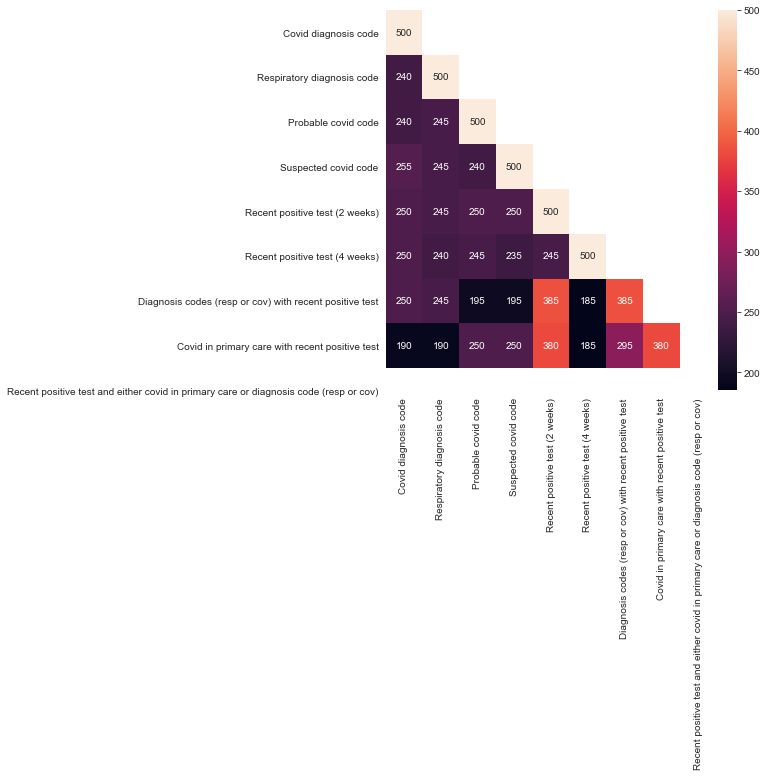

In [28]:
produce_matrix(columns_list = [ae_cov_before, ae_resp_before, ae_prim_care_probable_before, ae_prim_care_suspected_before, ae_pos_test_before_2_weeks, ae_pos_test_before, ae_hos_resp_cov_plus_test_2_weeks, ae_hosp_prim_care_before_plus_2_week_test], names=["Covid diagnosis code", "Respiratory diagnosis code", "Probable covid code", "Suspected covid code", "Recent positive test (2 weeks)", "Recent positive test (4 weeks)", "Diagnosis codes (resp or cov) with recent positive test", "Covid in primary care with recent positive test", "Recent positive test and either covid in primary care or diagnosis code (resp or cov)"], filename="cm_hosp_discharge")

## Number of emergency primary covid hospital admissions and those that can be identified in A&E attendances
### Any A&E attendance

In [30]:
df = pd.read_csv('output/input_prim_cov_2021-10-01.csv.gz')


num_emergency_cov_admissions = df['emergency_covid_hospital_admission_date'].count()
ae_before = (df.loc[
    df["ae_before_date"].notnull()
, "patient_id"])
print(f'Number of emergency primary covid hospital admissions: {num_emergency_cov_admissions}')
print(f'Number with A&E attendance before admission: {round_to_5(len(ae_before))} ({round((round_to_5(len(ae_before))/num_emergency_cov_admissions)*100, 2)}%)')

ae = round_to_5(len(df[
    (df["ae_attendance_date"].notnull())
]))

ae_with_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull())
]))

summary_table = pd.DataFrame({
    "emergency covid hospital admission": num_emergency_cov_admissions,
    "ae attendance before admission": round_to_5(len(ae_before)),
    "ae_attendance": ae, 
    "ae attendance with hospital discharge": ae_with_hosp_discharge,
    
}, index=["count"])

summary_table.to_csv("output/oct/summary_table_primary.csv")

print('---')
print(f'Number of A&E attendances: {ae}')

Number of emergency primary covid hospital admissions: 300
Number with A&E attendance before admission: 500 (166.67%)
---
Number of A&E attendances: 400


#### Method 1 - Discharge destination
Restrict to those that attended A&E and had a hospital discharge destination (hospital ward, emergency short stay ward, icu).

In [31]:
ae_hosp_before = (df.loc[
    df["ae_before_with_hospital_discharge_date"].notnull()
, "patient_id"])

print(f'Number with A&E attendance with hospital discharge before admission: {round_to_5(len(ae_hosp_before))} ({round((round_to_5(len(ae_hosp_before))/num_emergency_cov_admissions)*100, 2)}%)')


# false posisitves
fp_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)

]))

tp_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)

]))

tn_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].isnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)

]))

fn_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].isnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)

]))

discharge_destination = performance_metrics(tp_ae_hosp_discharge, fp_ae_hosp_discharge, tn_ae_hosp_discharge, fn_ae_hosp_discharge)

print(f'False positives (FDR): {fp_ae_hosp_discharge} ({discharge_destination[4]}%)')

Number with A&E attendance with hospital discharge before admission: 500 (166.67%)
False positives (FDR): 280 (70.0%)


#### Method 2 - Diagnosis code
Restrict to those with a COVID-19 diagnosis code or respiratory-related diagnosis code from the [emergency care diagnosis refset](https://termbrowser.nhs.uk/?perspective=full&conceptId1=991411000000109&edition=uk-edition&release=v20220216&server=https://termbrowser.nhs.uk/sct-browser-api/snomed&langRefset=900000000000508004)

In [32]:
ae_cov_before = (df.loc[
    df["ae_before_with_covid"]==1
, "patient_id"])

ae_resp_before = (df.loc[
    df["ae_before_with_resp"]==1
, "patient_id"])

print(f'Number with A&E attendance and covid diagnosis code before admission: {round_to_5(len(ae_cov_before))} ({round((round_to_5(len(ae_cov_before))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and respiratory code before admission: {round_to_5(len(ae_resp_before))} ({round((round_to_5(len(ae_resp_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_cov = round_to_5(len(df[
    (df["ae_cov"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fp_ae_resp = round_to_5(len(df[
    (df["ae_resp"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tp_ae_cov = round_to_5(len(df[
    (df["ae_cov"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tp_ae_resp = round_to_5(len(df[
    (df["ae_resp"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tn_ae_cov = round_to_5(len(df[
    (df["ae_cov"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tn_ae_resp = round_to_5(len(df[
    (df["ae_resp"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fn_ae_cov = round_to_5(len(df[
    (df["ae_cov"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

fn_ae_resp = round_to_5(len(df[
    (df["ae_resp"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

diagnosis_code_cov = performance_metrics(tp_ae_cov, fp_ae_cov, tn_ae_cov, fn_ae_cov)
diagnosis_code_resp = performance_metrics(tp_ae_resp, fp_ae_resp, tn_ae_resp, fn_ae_resp)

print(f'False positives (FDR) - A&E attendance and covid diagnosis code: {fp_ae_cov} ({diagnosis_code_cov[4]}%)')
print(f'False positives (FDR) - A&E attendance and respiratory diagnosis code: {fp_ae_resp} ({diagnosis_code_resp[4]}%)')

Number with A&E attendance and covid diagnosis code before admission: 500 (166.67%)
Number with A&E attendance and respiratory code before admission: 500 (166.67%)
False positives (FDR) - A&E attendance and covid diagnosis code: 340 (68.0%)
False positives (FDR) - A&E attendance and respiratory diagnosis code: 360 (72.0%)


#### Method 3 - Identification in primary care

Restrict to those with a probable or suspected COVID-19 code recorded in primary care in the 2 weeks prior to A&E attendance.

In [33]:
ae_prim_care_probable_before = (df.loc[
    df["ae_before_with_prim_care_probable"]==1
, "patient_id"])

ae_prim_care_suspected_before = (df.loc[
    df["ae_before_with_prim_care_suspected"]==1
, "patient_id"])

print(f'Number with A&E attendance and recent suspected covid code in primary care before admission: {round_to_5(len(ae_prim_care_suspected_before))} ({round((round_to_5(len(ae_prim_care_suspected_before))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and recent probable covid code in primary care before admission: {round_to_5(len(ae_prim_care_probable_before))} ({round((round_to_5(len(ae_prim_care_probable_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)    
]))

fp_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
]))

tp_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)    
]))

tp_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
]))

tn_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)    
]))

tn_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
]))

fn_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)    
]))

fn_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
]))



prim_care_suspected = performance_metrics(tp_ae_suspected, fp_ae_suspected, tn_ae_suspected, fn_ae_suspected)
prim_care_probable = performance_metrics(tp_ae_probable, fp_ae_probable, tn_ae_probable, fn_ae_probable)
print(f'False positives (FDR) - A&E attendance and probable covid code in primary care: {prim_care_probable[4]}%)')
print(f'False positives (FDR) - A&E attendance and suspected covid code in primary care: {prim_care_suspected[4]}%)')

Number with A&E attendance and recent suspected covid code in primary care before admission: 500 (166.67%)
Number with A&E attendance and recent probable covid code in primary care before admission: 500 (166.67%)
False positives (FDR) - A&E attendance and probable covid code in primary care: 70.0%)
False positives (FDR) - A&E attendance and suspected covid code in primary care: 70.0%)


#### Method 4 - Positive test result

Restrict to those with a positive COVID-19 test result recorded up to 4 weeks prior to A&E attendance.

In [34]:
ae_pos_test_before_2_weeks = (df.loc[
    df["ae_before_with_positive_covid_test_2_weeks"]==1
, "patient_id"])

ae_pos_test_before = (df.loc[
    df["ae_before_with_positive_covid_test"]==1
, "patient_id"])


print(f'Number with A&E attendance and recent positive test (2 weeks) before admission: {round_to_5(len(ae_pos_test_before_2_weeks))} ({round((round_to_5(len(ae_pos_test_before_2_weeks))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and recent positive test (4 weeks) before admissio: {round_to_5(len(ae_pos_test_before))} ({round((round_to_5(len(ae_pos_test_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_test = round_to_5(len(df[
    (df["pos_test"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fp_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tp_ae_test = round_to_5(len(df[
    (df["pos_test"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tp_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tn_ae_test = round_to_5(len(df[
    (df["pos_test"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tn_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fn_ae_test = round_to_5(len(df[
    (df["pos_test"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

fn_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))


positive_test_2_weeks = performance_metrics(tp_ae_test_2_weeks, fp_ae_test_2_weeks, tn_ae_test_2_weeks, fn_ae_test_2_weeks)
positive_test_4_weeks = performance_metrics(tp_ae_test, fp_ae_test, tn_ae_test, fn_ae_test)

print(f'False positives (FDR) - A&E attendance and recent positive test (2 weeks): {fp_ae_test_2_weeks} ({positive_test_2_weeks[4]}%)')
print(f'False positives (FDR) - A&E attendance and recent positive test (4 weeks): {fp_ae_test} ({positive_test_4_weeks[4]}%)')


Number with A&E attendance and recent positive test (2 weeks) before admission: 500 (166.67%)
Number with A&E attendance and recent positive test (4 weeks) before admissio: 500 (166.67%)
False positives (FDR) - A&E attendance and recent positive test (2 weeks): 355 (71.0%)
False positives (FDR) - A&E attendance and recent positive test (4 weeks): 355 (71.0%)


####  Combining approaches

##### Diagnosis codes (resp or cov) with recent positive test

In [35]:
ae_hos_resp_cov_plus_test_2_weeks = (df.loc[(
        (df["ae_before_with_covid"]==1) | 
        (df["ae_before_with_resp"]==1) 
    )&
    (df["ae_before_with_positive_covid_test_2_weeks"]==1)
, "patient_id"])

print(f'Number with A&E attendance with either covid or respiratory diagnosis code and recent positive test (2 weeks) before admission: {round_to_5(len(ae_hos_resp_cov_plus_test_2_weeks))} ({round((round_to_5(len(ae_hos_resp_cov_plus_test_2_weeks))/num_emergency_cov_admissions)*100, 2)}%)')


fp_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tp_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tn_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    ~(
    (
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fn_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    ~(
    (
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))


code_plus_test = performance_metrics(tp_ae_hos_resp_cov_plus_test_2_weeks, fp_ae_hos_resp_cov_plus_test_2_weeks, tn_ae_hos_resp_cov_plus_test_2_weeks, fn_ae_hos_resp_cov_plus_test_2_weeks)
print(f'False positives (FDR): {fp_ae_hos_resp_cov_plus_test_2_weeks} ({code_plus_test[4]}%)')


Number with A&E attendance with either covid or respiratory diagnosis code and recent positive test (2 weeks) before admission: 385 (128.33%)
False positives (FDR): 265 (69.74%)


##### Covid in primary care with recent positive test

In [36]:
ae_hosp_prim_care_before_plus_2_week_test = (df.loc[
    
    
    (
        (df["ae_before_with_prim_care_suspected"]==1) | 
        (df["ae_before_with_prim_care_probable"]==1) 
    )
&
    (df["ae_before_with_positive_covid_test_2_weeks"]==1)
, "patient_id"])

print(f'Number with A&E attendance with suspected or probable covid in primary care and recent positive test (2 weeks) before admission: {round_to_5(len(ae_hosp_prim_care_before_plus_2_week_test))} ({round((round_to_5(len(ae_hosp_prim_care_before_plus_2_week_test))/num_emergency_cov_admissions)*100, 2)}%)')


fp_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tp_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tn_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (~
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fn_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (~
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1)    
    )&
    (df["pos_test_2_weeks"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))


primary_care_plus_test = performance_metrics(tp_ae_hosp_prim_care_before_plus_2_week_test, fp_ae_hosp_prim_care_before_plus_2_week_test, tn_ae_hosp_prim_care_before_plus_2_week_test, fn_ae_hosp_prim_care_before_plus_2_week_test)

print(f'False positives (FDR): {fp_ae_hosp_prim_care_before_plus_2_week_test} ({primary_care_plus_test[4]}%)')


Number with A&E attendance with suspected or probable covid in primary care and recent positive test (2 weeks) before admission: 385 (128.33%)
False positives (FDR): 265 (70.67%)


##### Recent positive test and either covid in primary care or diagnosis code (resp or cov)

In [37]:
combined_before = (df.loc[
        (df["ae_before_with_positive_covid_test_2_weeks"]==1) &
        (
            (df["ae_before_with_prim_care_suspected"]==1) | 
            (df["ae_before_with_prim_care_probable"]==1) |
            (df["ae_before_with_covid"]==1) | 
            (df["ae_before_with_resp"]==1)   
        )
, "patient_id"])

print(f'Number with A&E attendance with recent positive test and either suspected or probable covid in primary care or a covid or respiratory diagnosis code on attendance: {round_to_5(len(combined_before))} ({round((round_to_5(len(combined_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_combined_before = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1) |
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)
        
        
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

tp_combined_before = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1) |
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)
    )&
    (df["pos_test_2_weeks"]==1)&
    (df["emergency_covid_hospital_admission_after_ae"]==1)
    
]))

tn_combined_before = round_to_5(len(df[
    (~
        (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1) |
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)
    )&
    (df["pos_test_2_weeks"]==1)
    )
    & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

fn_combined_before = round_to_5(len(df[
    (~
        (
        (df["covid_primary_care_before_ae"]==1) |
        (df["suspected_covid_primary_care_before_ae"]==1) |
        (df["ae_cov"]==1) |
        (df["ae_resp"]==1)
    )&
    (df["pos_test_2_weeks"]==1)
    )
    & 
    (df["emergency_covid_hospital_admission_after_ae"]==0)
    
]))

pos_test_prim_care_or_diagnosis_code = performance_metrics(tp_combined_before, fp_combined_before, tn_combined_before, fn_combined_before)
print(f'False positives (FDR): {fp_combined_before} ({pos_test_prim_care_or_diagnosis_code[4]}%)')


Number with A&E attendance with recent positive test and either suspected or probable covid in primary care or a covid or respiratory diagnosis code on attendance: 475 (158.33%)
False positives (FDR): 335 (71.28%)


In [38]:
identification_table_index = ["tp", "fp", "sensitivity", "specificity", "fdr"]
identification_table = pd.DataFrame({
    "discharge_destination": pd.Series(discharge_destination,index=identification_table_index),
    "covid_diagnosis_code": pd.Series(diagnosis_code_cov,index=identification_table_index),
    "resp_diagnosis_code": pd.Series(diagnosis_code_resp,index=identification_table_index),
    "primary_care_suspected": pd.Series(prim_care_suspected,index=identification_table_index),
    "primary_care_probable": pd.Series(prim_care_probable,index=identification_table_index),
    "positive_test_2_weeks": pd.Series(positive_test_2_weeks,index=identification_table_index),
    "positive_test_4_weeks": pd.Series(positive_test_4_weeks,index=identification_table_index),
    "diagnosis_code_with_positive_test": pd.Series(code_plus_test,index=identification_table_index),
    "primary_care_with_positive_test": pd.Series(primary_care_plus_test,index=identification_table_index),
    "pos_test_prim_care_or_diagnosis": pd.Series(pos_test_prim_care_or_diagnosis_code,index=identification_table_index)
    
})
identification_table.to_csv("output/oct/identification_table_no_hosp_discharge_primary.csv")

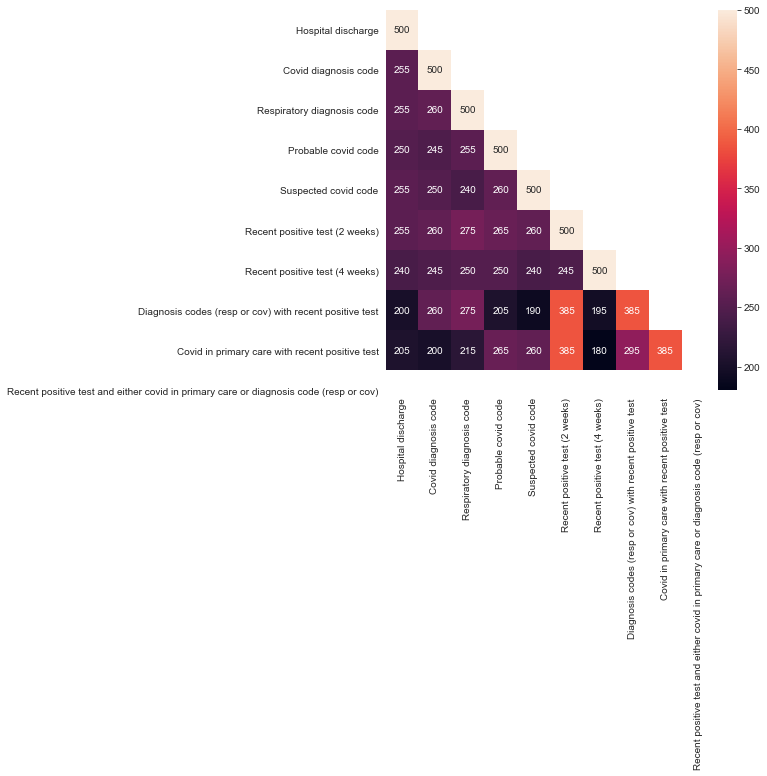

In [39]:
produce_matrix(columns_list = [ae_hosp_before, ae_cov_before, ae_resp_before, ae_prim_care_probable_before, ae_prim_care_suspected_before, ae_pos_test_before_2_weeks, ae_pos_test_before, ae_hos_resp_cov_plus_test_2_weeks, ae_hosp_prim_care_before_plus_2_week_test], names=["Hospital discharge", "Covid diagnosis code", "Respiratory diagnosis code", "Probable covid code", "Suspected covid code", "Recent positive test (2 weeks)", "Recent positive test (4 weeks)", "Diagnosis codes (resp or cov) with recent positive test", "Covid in primary care with recent positive test", "Recent positive test and either covid in primary care or diagnosis code (resp or cov)"], filename="cm_no_hosp_discharge")


### Restrict to A&E attendance with hospital discharge

In [40]:
ae_with_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull())
]))
print(f'Number of A&E attendances with hospital discharge: {ae_with_hosp_discharge}')

Number of A&E attendances with hospital discharge: 400


#### Method 1 - Discharge destination
Restrict to those that attended A&E and had a hospital discharge destination (hospital ward, emergency short stay ward, icu).

In [41]:
ae_hosp_before = (df.loc[
    df["ae_before_with_hospital_discharge_date"].notnull()
, "patient_id"])

print(f'Number with A&E attendance with hospital discharge before admission: {round_to_5(len(ae_hosp_before))} ({round((round_to_5(len(ae_hosp_before))/num_emergency_cov_admissions)*100, 2)}%)')


# false posisitves
fp_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)

]))

tp_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].notnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)

]))

tn_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].isnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)

]))

fn_ae_hosp_discharge = round_to_5(len(df[
    (df["ae_attendance_hosp_discharge_date"].isnull()) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)

]))

discharge_destination = performance_metrics(tp_ae_hosp_discharge, fp_ae_hosp_discharge, tn_ae_hosp_discharge, fn_ae_hosp_discharge)
print(f'False positives (FDR): {fp_ae_hosp_discharge} ({discharge_destination[4]}%)')

Number with A&E attendance with hospital discharge before admission: 500 (166.67%)
False positives (FDR): 280 (70.0%)


#### Method 2 - Diagnosis code
Restrict to those with a COVID-19 diagnosis code or respiratory-related diagnosis code from the [emergency care diagnosis refset](https://termbrowser.nhs.uk/?perspective=full&conceptId1=991411000000109&edition=uk-edition&release=v20220216&server=https://termbrowser.nhs.uk/sct-browser-api/snomed&langRefset=900000000000508004)

In [42]:
ae_cov_before = (df.loc[
    df["ae_before_with_hospital_discharge_covid"]==1
, "patient_id"])

ae_resp_before = (df.loc[
    df["ae_before_with_hospital_discharge_resp"]==1
, "patient_id"])

print(f'Number with A&E attendance and covid diagnosis code before admission: {round_to_5(len(ae_cov_before))} ({round((round_to_5(len(ae_cov_before))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and respiratory code before admission: {round_to_5(len(ae_resp_before))} ({round((round_to_5(len(ae_resp_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_cov = round_to_5(len(df[
    (df["ae_cov_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fp_ae_resp = round_to_5(len(df[
    (df["ae_resp_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tp_ae_cov = round_to_5(len(df[
    (df["ae_cov_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tp_ae_resp = round_to_5(len(df[
    (df["ae_resp_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tn_ae_cov = round_to_5(len(df[
    (df["ae_cov_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tn_ae_resp = round_to_5(len(df[
    (df["ae_resp_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fn_ae_cov = round_to_5(len(df[
    (df["ae_cov_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

fn_ae_resp = round_to_5(len(df[
    (df["ae_resp_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))



diagnosis_code_cov = performance_metrics(tp_ae_cov, fp_ae_cov, tn_ae_cov, fn_ae_cov)
diagnosis_code_resp = performance_metrics(tp_ae_resp, fp_ae_resp, tn_ae_resp, fn_ae_resp)

print(f'False positives (FDR) - A&E attendance and covid diagnosis code: {fp_ae_cov} ({diagnosis_code_cov[4]}%)')
print(f'False positives (FDR) - A&E attendance and respiratory diagnosis code: {fp_ae_resp} ({diagnosis_code_resp[4]}%)')

Number with A&E attendance and covid diagnosis code before admission: 500 (166.67%)
Number with A&E attendance and respiratory code before admission: 500 (166.67%)
False positives (FDR) - A&E attendance and covid diagnosis code: 350 (70.0%)
False positives (FDR) - A&E attendance and respiratory diagnosis code: 340 (68.0%)


#### Method 3 - Identification in primary care

Restrict to those with a probable or suspected COVID-19 code recorded in primary care in the 2 weeks prior to A&E attendance.

In [43]:
ae_prim_care_probable_before = (df.loc[
    df["ae_before_with_hospital_discharge_prim_care_probable"]==1
, "patient_id"])

ae_prim_care_suspected_before = (df.loc[
    df["ae_before_with_hospital_discharge_prim_care_suspected"]==1
, "patient_id"])

print(f'Number with A&E attendance and recent suspected covid code in primary care before admission: {round_to_5(len(ae_prim_care_suspected_before))} ({round((round_to_5(len(ae_prim_care_suspected_before))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and recent probable covid code in primary care before admission: {round_to_5(len(ae_prim_care_probable_before))} ({round((round_to_5(len(ae_prim_care_probable_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)    
]))

fp_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
]))

tp_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)    
]))

tp_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
]))

tn_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)    
]))

tn_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
]))

fn_ae_suspected = round_to_5(len(df[
    (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)    
]))

fn_ae_probable = round_to_5(len(df[
    (df["covid_primary_care_before_ae_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
]))



prim_care_suspected = performance_metrics(tp_ae_suspected, fp_ae_suspected, tn_ae_suspected, fn_ae_suspected)
prim_care_probable = performance_metrics(tp_ae_probable, fp_ae_probable, tn_ae_probable, fn_ae_probable)

print(f'False positives (FDR) - A&E attendance and probable covid code in primary care: {fp_ae_probable} ({prim_care_probable[4]}%)')
print(f'False positives (FDR) - A&E attendance and suspected covid code in primary care: {fp_ae_suspected} ({prim_care_suspected[4]}%)')

Number with A&E attendance and recent suspected covid code in primary care before admission: 500 (166.67%)
Number with A&E attendance and recent probable covid code in primary care before admission: 500 (166.67%)
False positives (FDR) - A&E attendance and probable covid code in primary care: 350 (70.0%)
False positives (FDR) - A&E attendance and suspected covid code in primary care: 350 (70.0%)


#### Method 4 - Positive test result

Restrict to those with a positive COVID-19 test result recorded up to 4 weeks prior to A&E attendance.

In [44]:
ae_pos_test_before_2_weeks = (df.loc[
    df["ae_before_with_hospital_discharge_positive_covid_test_2_weeks"]==1
, "patient_id"])

ae_pos_test_before = (df.loc[
    df["ae_before_with_hospital_discharge_positive_covid_test"]==1
, "patient_id"])


print(f'Number with A&E attendance and recent positive test (2 weeks) before admission: {round_to_5(len(ae_pos_test_before_2_weeks))} ({round((round_to_5(len(ae_pos_test_before_2_weeks))/num_emergency_cov_admissions)*100, 2)}%)')
print(f'Number with A&E attendance and recent positive test (4 weeks) before admissio: {round_to_5(len(ae_pos_test_before))} ({round((round_to_5(len(ae_pos_test_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_ae_test = round_to_5(len(df[
    (df["pos_test_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fp_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tp_ae_test = round_to_5(len(df[
    (df["pos_test_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tp_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks_hosp_discharge"]==1) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tn_ae_test = round_to_5(len(df[
    (df["pos_test_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tn_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fn_ae_test = round_to_5(len(df[
    (df["pos_test_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

fn_ae_test_2_weeks = round_to_5(len(df[
    (df["pos_test_2_weeks_hosp_discharge"]==0) & 
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

positive_test_2_weeks = performance_metrics(tn_ae_test_2_weeks, fp_ae_test_2_weeks, tn_ae_test_2_weeks, fn_ae_test_2_weeks)
positive_test_4_weeks = performance_metrics(tn_ae_test, fp_ae_test, tn_ae_test, fn_ae_test)

print(f'False positives (FDR) - A&E attendance and recent positive test (2 weeks): {fp_ae_test_2_weeks} ({positive_test_2_weeks[4]}%)')
print(f'False positives (FDR) - A&E attendance and recent positive test (4 weeks): {fp_ae_test} ({positive_test_4_weeks[4]}%)')

Number with A&E attendance and recent positive test (2 weeks) before admission: 500 (166.67%)
Number with A&E attendance and recent positive test (4 weeks) before admissio: 500 (166.67%)
False positives (FDR) - A&E attendance and recent positive test (2 weeks): 335 (47.86%)
False positives (FDR) - A&E attendance and recent positive test (4 weeks): 340 (48.57%)


####  Combining approaches

##### Diagnosis codes (resp or cov) with recent positive test

In [45]:
ae_hos_resp_cov_plus_test_2_weeks = (df.loc[(
        (df["ae_before_with_hospital_discharge_covid"]==1) | 
        (df["ae_before_with_hospital_discharge_resp"]==1) 
    )&
    (df["ae_before_with_hospital_discharge_positive_covid_test_2_weeks"]==1)
, "patient_id"])

print(f'Number with A&E attendance with either covid or respiratory diagnosis code and recent positive test (2 weeks) before admission: {round_to_5(len(ae_hos_resp_cov_plus_test_2_weeks))} ({round((round_to_5(len(ae_hos_resp_cov_plus_test_2_weeks))/num_emergency_cov_admissions)*100, 2)}%)')


fp_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tp_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tn_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (~
        (
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))


fn_ae_hos_resp_cov_plus_test_2_weeks = round_to_5(len(df[
    (~
        (
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

code_plus_test = performance_metrics(tp_ae_hos_resp_cov_plus_test_2_weeks, fp_ae_hos_resp_cov_plus_test_2_weeks, tn_ae_hos_resp_cov_plus_test_2_weeks, fn_ae_hos_resp_cov_plus_test_2_weeks)
print(f'False positives (FDR): {fp_ae_hos_resp_cov_plus_test_2_weeks} ({code_plus_test[4]}%)')


Number with A&E attendance with either covid or respiratory diagnosis code and recent positive test (2 weeks) before admission: 370 (123.33%)
False positives (FDR): 255 (65.38%)


##### Covid in primary care with recent positive test

In [46]:
ae_hosp_prim_care_before_plus_2_week_test = (df.loc[(
        (df["ae_before_with_hospital_discharge_prim_care_suspected"]==1) | 
        (df["ae_before_with_hospital_discharge_prim_care_probable"]==1) 
    )
&
    (df["ae_before_with_hospital_discharge_positive_covid_test_2_weeks"]==1)
, "patient_id"])

print(f'Number with A&E attendance with suspected or probable covid in primary care and recent positive test (2 weeks) before admission: {round_to_5(len(ae_hosp_prim_care_before_plus_2_week_test))} ({round((round_to_5(len(ae_hosp_prim_care_before_plus_2_week_test))/num_emergency_cov_admissions)*100, 2)}%)')


fp_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tp_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tn_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (~(
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fn_ae_hosp_prim_care_before_plus_2_week_test = round_to_5(len(df[
    (~(
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1)    
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))


primary_care_plus_test = performance_metrics(tp_ae_hosp_prim_care_before_plus_2_week_test, fp_ae_hosp_prim_care_before_plus_2_week_test, tn_ae_hosp_prim_care_before_plus_2_week_test, fn_ae_hosp_prim_care_before_plus_2_week_test)
print(f'False positives (FDR): {fp_ae_hosp_prim_care_before_plus_2_week_test} ({primary_care_plus_test[4]}%)')


Number with A&E attendance with suspected or probable covid in primary care and recent positive test (2 weeks) before admission: 370 (123.33%)
False positives (FDR): 250 (65.79%)


##### Recent positive test and either covid in primary care or diagnosis code (resp or cov)

In [47]:
combined_before = (df.loc[
        (df["ae_before_with_hospital_discharge_positive_covid_test_2_weeks"]==1) &
        (
            (df["ae_before_with_hospital_discharge_prim_care_suspected"]==1) | 
            (df["ae_before_with_hospital_discharge_prim_care_probable"]==1) |
            (df["ae_before_with_hospital_discharge_covid"]==1) | 
            (df["ae_before_with_hospital_discharge_resp"]==1)   
        )
, "patient_id"])

print(f'Number with A&E attendance with recent positive test and either suspected or probable covid in primary care or a covid or respiratory diagnosis code on attendance: {round_to_5(len(combined_before))} ({round((round_to_5(len(combined_before))/num_emergency_cov_admissions)*100, 2)}%)')

fp_combined_before = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)
        
        
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

tp_combined_before = round_to_5(len(df[
    (
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)&
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

tn_combined_before = round_to_5(len(df[
    (~(
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==0)
    
]))

fn_combined_before = round_to_5(len(df[
    (~(
        (df["covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["suspected_covid_primary_care_before_ae_hosp_discharge"]==1) |
        (df["ae_cov_hosp_discharge"]==1) |
        (df["ae_resp_hosp_discharge"]==1)
    )&
    (df["pos_test_2_weeks_hosp_discharge"]==1)
    )
    &
    (df["emergency_covid_hospital_admission_after_ae_hosp_discharge"]==1)
    
]))

pos_test_prim_care_or_diagnosis_code = performance_metrics(tp_combined_before, fp_combined_before, tn_combined_before, fn_combined_before)
print(f'False positives (FDR): {fp_combined_before} ({pos_test_prim_care_or_diagnosis_code}%)')


Number with A&E attendance with recent positive test and either suspected or probable covid in primary care or a covid or respiratory diagnosis code on attendance: 470 (156.67%)
False positives (FDR): 315 ([160, 315, 66.32, 5.97, 66.32]%)


In [48]:
identification_table_index = ["tp", "fp", "sensitivity", "specificity", "fdr"]
identification_table = pd.DataFrame({
    "discharge_destination": pd.Series(discharge_destination,index=identification_table_index),
    "covid_diagnosis_code": pd.Series(diagnosis_code_cov,index=identification_table_index),
    "resp_diagnosis_code": pd.Series(diagnosis_code_resp,index=identification_table_index),
    "primary_care_suspected": pd.Series(prim_care_suspected,index=identification_table_index),
    "primary_care_probable": pd.Series(prim_care_probable,index=identification_table_index),
    "positive_test_2_weeks": pd.Series(positive_test_2_weeks,index=identification_table_index),
    "positive_test_4_weeks": pd.Series(positive_test_4_weeks,index=identification_table_index),
    "diagnosis_code_with_positive_test": pd.Series(code_plus_test,index=identification_table_index),
    "primary_care_with_positive_test": pd.Series(primary_care_plus_test,index=identification_table_index),
    "pos_test_prim_care_or_diagnosis": pd.Series(pos_test_prim_care_or_diagnosis_code,index=identification_table_index)
    
})
identification_table.to_csv("output/oct/identification_table_hosp_discharge_primary.csv")

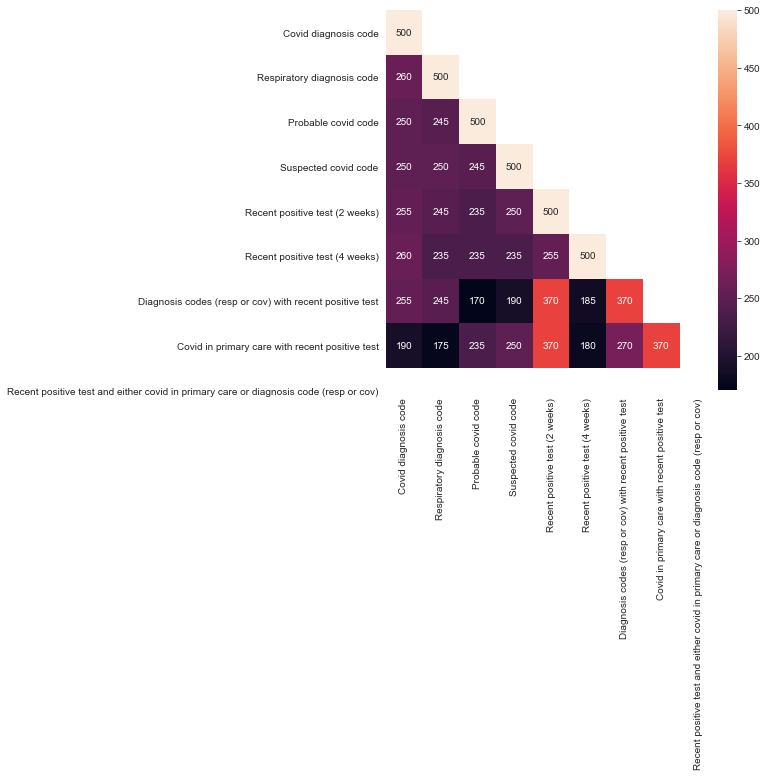

In [49]:
produce_matrix(columns_list = [ae_cov_before, ae_resp_before, ae_prim_care_probable_before, ae_prim_care_suspected_before, ae_pos_test_before_2_weeks, ae_pos_test_before, ae_hos_resp_cov_plus_test_2_weeks, ae_hosp_prim_care_before_plus_2_week_test], names=["Covid diagnosis code", "Respiratory diagnosis code", "Probable covid code", "Suspected covid code", "Recent positive test (2 weeks)", "Recent positive test (4 weeks)", "Diagnosis codes (resp or cov) with recent positive test", "Covid in primary care with recent positive test", "Recent positive test and either covid in primary care or diagnosis code (resp or cov)"], filename="cm_hosp_discharge")